In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse
import seaborn as sns
%matplotlib inline

## Import & visualize data

In [4]:
movies = pd.read_csv("movies.csv") # details on the movies in the movielens dataset
ratings = pd.read_csv("ratings.csv") #the ratings the movielens community gave to movies
chris = pd.read_csv("chris ratings.csv") # my own ratings exported from movielens

In [ ]:
movies.head(5)

In [22]:
ratings.head(5)

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [5]:
# Set style options
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
sns.set(rc={'figure.figsize':(10,6)})
sns.set(font_scale=1.3)

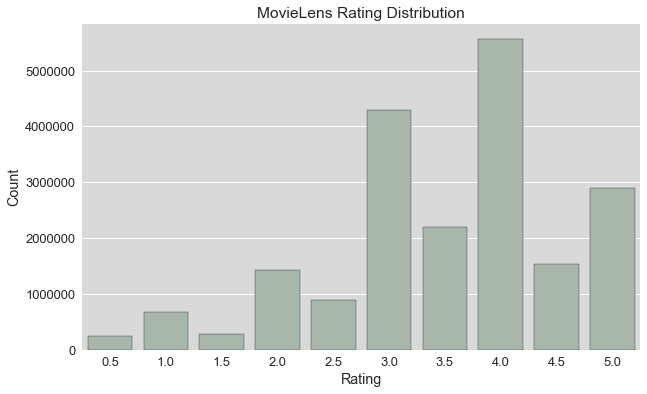

In [6]:
sns.set_style("darkgrid", {'axes.facecolor': '#d9d9d9', 'figure.facecolor': 'None'})

# Create countplot with counts of ratings for the MovieLens users
gMLR = sns.countplot(ratings.rating, color = '#A3B9AA', edgecolor = 'k') 
gMLR.set_title('MovieLens Rating Distribution')                          
gMLR.set_xlabel('Rating')                                                
gMLR.set_ylabel('Count')
gMLR.figure.set_facecolor('None')

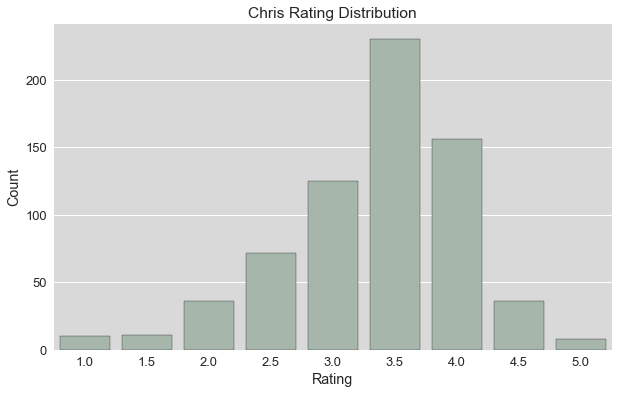

In [7]:
# Create countplot with counts of my own ratings
gCR = sns.countplot(chris.rating, color = '#A3B9AA', edgecolor = 'k')
gCR.set_title('Chris Rating Distribution')
gCR.set_xlabel('Rating')
gCR.set_ylabel('Count')
gCR.figure.set_facecolor('None')

In [8]:
# Aggregate the amount of movies watched and the mean rating for each user
ratings_agg = ratings[["userId","movieId","rating"]].groupby("userId").agg(['count','mean']).iloc[:,[0,3]]
ratings_agg.columns = ["movie_count", "mean_rating"]

In [9]:
ratings_agg

,movie_count,mean_rating
userId,,
1,175,3.742857
2,61,4.000000
3,187,4.122995
4,28,3.571429
5,66,4.272727
6,24,3.750000
7,276,3.289855
8,70,3.800000
9,35,3.057143


C:\Users\Chris\Anaconda3\lib\site-packages\seaborn\distributions.py:218: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)


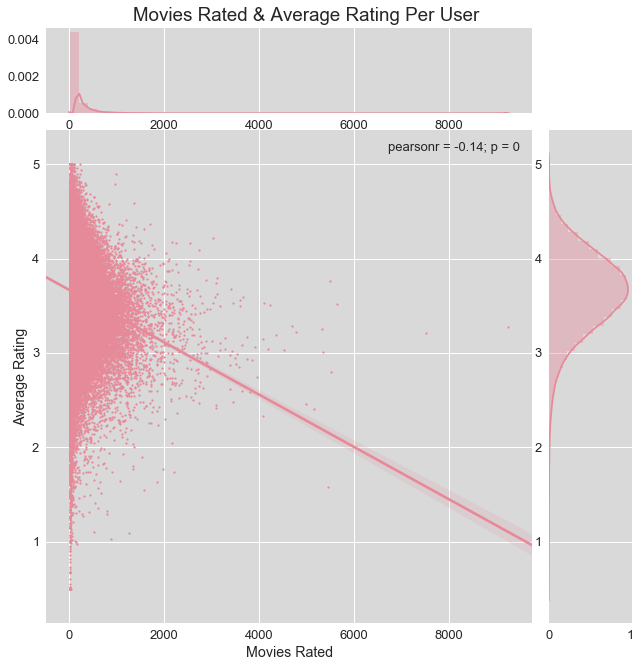

In [10]:
# Create a jointplot with the number of movies rated and average rating per MovieLens user inluding distributions and scatterplot
sns.set_style("darkgrid", {'axes.facecolor': '#d9d9d9', 'figure.facecolor': 'None'})
g = sns.jointplot(x='movie_count', y='mean_rating',
                  data = ratings_agg ,
                  kind='reg', 
                  color = '#E68A99',
                  scatter_kws={"s": 5, 'alpha':1})
g.fig.suptitle('Movies Rated & Average Rating Per User')
g.set_axis_labels('Movies Rated', 'Average Rating')
g.fig.set_size_inches(10,10)

### Transform data

In [11]:
# Convert the rating column from float64 to float32 to save space and convert movieId and userId from float64 to objects (str)
ratings["rating"] = ratings["rating"].astype("float32")
ratings["userId"] = ratings["userId"].astype("object")
ratings["movieId"] = ratings["movieId"].astype("object")
movies["movieId"] = movies["movieId"].astype("object")
chris["movie_id"] = chris["movie_id"].astype("object")

chris["userId"] = "Chris" # Add userId to identify my own ratings when I add them to the ratings df later
chris = chris[["userId", "movie_id", "rating"]] # Only keep the userId, movie_id and rating columns
chris.columns = ['userId', 'movieId', 'rating'] # Rename movie_id to movieId so it is consistent with the ratings df

# Remove movies in rated that are not rated by anyone else (e.g. because they weren't yet released)
chris = chris[chris["movieId"].isin(list(ratings["movieId"]))]

# Drop the timestamp column in the ratings dataframe, because we do not use it
ratings = ratings.drop("timestamp", axis = 1)

# Merge movie information (especially title) with the ratings for each movie
movieratings = pd.merge(ratings, movies, on = "movieId")

In [12]:
# From the ratings df grab the 999 users (user IDs) with the most ratings (I will add myself later to make it 1000)
top1k = ratings.set_index(["userId", "movieId"]).count(level="userId").sort_values(by = ['rating'], ascending = False)[:999]

#Grab the movie ratings of those 999 users and cast them into a dataframe
filtered = ratings[ratings['userId'].isin(list(top1k.index))].reset_index().drop('index', axis = 1)

# Add my own movieratings to this dataframe
filtered = filtered.append(chris)

# Transform the dataframe into a user-item matrix with the row index representing the userId and the columns representing the movieIds
ratings_table = pd.pivot_table(filtered, values = ['rating'], index = ['userId'], columns=['movieId'])
ratings_table.columns = ratings_table.columns.droplevel(0)

print(ratings_table)

movieId  1       2       3       4       5       6       7       8       \
userId                                                                    
156         5.0     5.0     2.0     3.0     3.0     4.0     4.0     NaN   
208         4.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
359         5.0     NaN     NaN     NaN     NaN     5.0     NaN     NaN   
572         5.0     3.5     3.5     NaN     3.5     NaN     NaN     NaN   
586         2.5     3.0     2.0     NaN     3.0     4.5     NaN     NaN   
741         5.0     3.0     3.0     NaN     4.0     3.5     4.5     NaN   
768         NaN     3.0     NaN     NaN     2.0     4.0     NaN     NaN   
775         4.5     2.0     3.5     NaN     1.0     3.5     3.0     NaN   
903         4.0     4.0     2.0     2.0     3.0     4.0     3.0     3.0   
982         3.0     2.0     2.0     2.0     2.5     3.5     2.0     NaN   
1507        4.0     3.0     2.5     NaN     1.5     3.0     NaN     NaN   
1763        4.0     4.0  

#### Create co-occurence  matrix

First we create a co-occurence matrix by computing the pairwise counts for each user pair.
This matrix illustrates the number of movies which both of the users rated.
We can use the co-occurence values afterwards to weight the distances in users tastes.
Moreover, it gives us a property to filter on in case we only want to consider comparing a user with other users that watched
at least 'x' number of the same movies.

In [14]:
# Create a new matrix in which we transformed each value in our user-item matrix to 1 and each NaN to 0
watched_mat = ratings_table.notnull().astype('int')

# Create the co-occurrence matrix by computing the dot product of the matrix with the transposed version of the matrix
coocc = watched_mat.dot(watched_mat.T)

print(coocc)

userId   156   208   359   572   586   741   768   775   903   982  ...    \
userId                                                              ...     
156     2179   477   449   455   541   796   658  1016  1440   979  ...     
208      477  1288   379   342   402   469   356   644   681   605  ...     
359      449   379  1300   471   546   462   566   565   516   684  ...     
572      455   342   471  1326   584   412   539   534   532   639  ...     
586      541   402   546   584  1431   496   793   645   611   783  ...     
741      796   469   462   412   496  2212   619   798   999   869  ...     
768      658   356   566   539   793   619  1769   712   727   976  ...     
775     1016   644   565   534   645   798   712  1957  1315  1119  ...     
903     1440   681   516   532   611   999   727  1315  2608  1236  ...     
982      979   605   684   639   783   869   976  1119  1236  2183  ...     
1507     661   416   565   514   628   600   672   810   777   897  ...     

## Modeling

In [9]:
def MostSimilarUsers(user_item_mat, coocc_mat, dist_metric, main_user_id, min_cooccurrences = 100 , n_most_similar_users = 10, weighted = False):

    # Compute distance matrix by using either the absolute, eucildean or cosine distance metric
    if dist_metric == "absolute":
        dist_mat = cdist(user_item_mat, user_item_mat, lambda u, v: np.nansum(abs((u-v))))
    elif dist_metric == "euclidean":
        dist_mat = cdist(user_item_mat, user_item_mat, lambda u, v: np.sqrt(np.nansum((u-v)**2)))
    elif dist_metric == "cosine":
        dist_mat = cdist(user_item_mat.fillna(0), user_item_mat.fillna(0), "cosine")
        
    # Compute similarity matrix by using either the absolute, eucildean or cosine distance metric
    if dist_metric == "absolute":
        dist_mat = cdist(user_item_mat, user_item_mat, lambda u, v: np.nansum(abs((u-v))))
    elif dist_metric == "euclidean":
        dist_mat = cdist(user_item_mat, user_item_mat, lambda u, v: np.sqrt(np.nansum((u-v)**2)))
    elif dist_metric == "cosine":
        dist_mat = cdist(user_item_mat.fillna(0), user_item_mat.fillna(0), "cosine")
        
    # Cast distance matrix into dataframe
    dist = pd.DataFrame(dist_mat, index = list(user_item_mat.index), columns = list(user_item_mat.index))
    
    # If specified, divide the total distance by total amount of cooccurrences in other to get a distance per movie metric
    if weighted == True:
        dist = dist / coocc
    
    main_distances = list(dist.loc[str(main_user_id)]) # Cast the distances between the main user and the other users in a list
    ratings_shared = list(coocc.loc[str(main_user_id)]) # Cast the counts of movies both rated by the main user and the other user (cooccurrences) in a list

    # Create a dataframe with these two lists as columns
    main_dist = pd.DataFrame(data = [main_distances, ratings_shared]).transpose()
    main_dist.index = user_item_mat.index
    main_dist.columns = ["dist", "cooccurrences"]
    main_dist = main_dist.drop(str(main_user_id)) # Drop the distance of the main user to itself
    
    # Filter out the users that have not seen enough of the same movies as the main user
    main_dist = main_dist[main_dist["cooccurrences"] >= min_cooccurrences] 

    # Return the 10 users with the smallest distance to the main user
    return(main_dist.nsmallest(n_most_similar_users, "dist"))

#### Compute the absolute distance between the users

In order to determine how similar each user's taste is to that of the other users, we need to calculate to what extent the 
the ratings the users gave to the movies match (or vary). There is an abundance of distance/similarity metrics including Euclidean distance and cosine similarity. First we will look at the absolute distance between the pairs of user ratings.

In [10]:
from scipy.spatial.distance import cdist

            dist  cooccurrences
userId                         
130193  0.473958          192.0
70201   0.507092          282.0
127713  0.513514          111.0
15720   0.545259          232.0
107579  0.571429          147.0
93234   0.574661          221.0
54549   0.576087          138.0
67443   0.582524          206.0
58426   0.584362          243.0
114933  0.586294          197.0


,userId_x,movieId,rating_x,title,genres,userId_y,rating_y
0,130193,1208,4.5,Apocalypse Now (1979),Action|Drama|War,Chris,2.0
1,130193,1221,4.5,"Godfather: Part II, The (1974)",Crime|Drama,Chris,4.0
2,130193,1198,4.5,Raiders of the Lost Ark (Indiana Jones and the...,Action|Adventure,Chris,2.0
3,130193,1196,4.5,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi,Chris,4.0
4,130193,1193,4.5,One Flew Over the Cuckoo's Nest (1975),Drama,Chris,3.5
5,130193,5995,4.5,"Pianist, The (2002)",Drama|War,Chris,3.5
6,130193,111,4.5,Taxi Driver (1976),Crime|Drama|Thriller,Chris,5.0
7,130193,356,4.5,Forrest Gump (1994),Comedy|Drama|Romance|War,Chris,2.0
8,130193,318,4.5,"Shawshank Redemption, The (1994)",Crime|Drama,Chris,4.0
9,130193,296,4.5,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,Chris,4.5


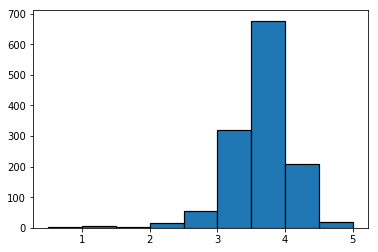

In [11]:
closest_abs_dist = MostSimilarUsers(user_item_mat = ratings_table, coocc_mat = coocc, dist_metric = "absolute", main_user_id = "Chris", weighted = True)
print(closest_abs_dist)
pd.set_option('display.max_rows', 500)


plt.hist(ratings["rating"][ratings["userId"] == closest_abs_dist.index[0]], bins = 9, edgecolor='black', linewidth=1.2)
# Inspect the ratings of the user closest to me to see if his/her taste matches with my own
pd.merge(movieratings[movieratings["userId"] == closest_abs_dist.index[0]].sort_values("rating", ascending = False), chris, on = "movieId")

#### Compute the euclidean distance between the users

            dist  cooccurrences
userId                         
70201   0.042182          282.0
131904  0.044619          341.0
3907    0.047668          300.0
34576   0.047842          326.0
104345  0.048058          358.0
32094   0.048718          353.0
12131   0.049502          268.0
15617   0.049970          327.0
80034   0.050108          274.0
64572   0.050167          278.0


,userId_x,movieId,rating_x,title,genres,userId_y,rating_y
0,70201,1201,4.5,"Good, the Bad and the Ugly, The (Buono, il bru...",Action|Adventure|Western,Chris,3.0
1,70201,3578,4.0,Gladiator (2000),Action|Adventure|Drama,Chris,3.5
2,70201,1228,4.0,Raging Bull (1980),Drama,Chris,3.5
3,70201,1221,4.0,"Godfather: Part II, The (1974)",Crime|Drama,Chris,4.0
4,70201,6440,4.0,Barton Fink (1991),Drama|Thriller,Chris,3.5
5,70201,8950,4.0,"Machinist, The (Maquinista, El) (2004)",Mystery|Thriller,Chris,4.0
6,70201,3683,4.0,Blood Simple (1984),Crime|Drama|Film-Noir,Chris,3.5
7,70201,1213,4.0,Goodfellas (1990),Crime|Drama,Chris,4.0
8,70201,2329,4.0,American History X (1998),Crime|Drama,Chris,4.5
9,70201,1206,4.0,"Clockwork Orange, A (1971)",Crime|Drama|Sci-Fi|Thriller,Chris,4.0


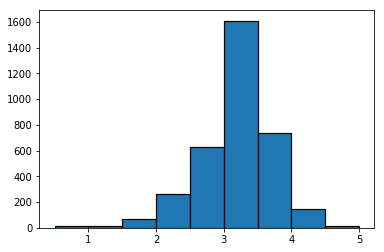

In [12]:
closest_euc_dist = MostSimilarUsers(user_item_mat = ratings_table, coocc_mat = coocc, dist_metric = "euclidean", main_user_id = "Chris", weighted = True)
print(closest_euc_dist)

plt.hist(ratings["rating"][ratings["userId"] == closest_euc_dist.index[0]], bins = 9, edgecolor='black', linewidth=1.2)
# Inspect the ratings of the user closest to me to see if his/her taste matches with my own
pd.merge(movieratings[movieratings["userId"] == closest_euc_dist.index[0]].sort_values("rating", ascending = False), chris, on = "movieId")

#### Compute the cosine distance between the users

Now that we have computed and evaluated the absolute distance, let's compute the cosine distance between the pairs of user ratings.

            dist  cooccurrences
userId                         
97533   0.569607          358.0
32094   0.598357          353.0
87561   0.605918          341.0
80034   0.609661          274.0
51245   0.611577          270.0
3676    0.611795          288.0
24945   0.612912          266.0
28688   0.620741          249.0
23180   0.622649          286.0
84476   0.624041          288.0


,userId_x,movieId,rating_x,title,genres,userId_y,rating_y
0,97533,8157,5.0,Jin Roh: The Wolf Brigade (Jin-Rô) (1998),Animation|Fantasy|Thriller,Chris,3.5
1,97533,2455,5.0,"Fly, The (1986)",Drama|Horror|Sci-Fi|Thriller,Chris,3.0
2,97533,3703,5.0,"Road Warrior, The (Mad Max 2) (1981)",Action|Adventure|Sci-Fi,Chris,4.0
3,97533,2160,5.0,Rosemary's Baby (1968),Drama|Horror|Thriller,Chris,4.5
4,97533,1732,5.0,"Big Lebowski, The (1998)",Comedy|Crime,Chris,3.5
5,97533,7116,5.0,Diabolique (Les diaboliques) (1955),Horror|Mystery|Thriller,Chris,3.0
6,97533,8014,5.0,"Spring, Summer, Fall, Winter... and Spring (Bo...",Drama,Chris,3.5
7,97533,778,5.0,Trainspotting (1996),Comedy|Crime|Drama,Chris,3.0
8,97533,1884,5.0,Fear and Loathing in Las Vegas (1998),Adventure|Comedy|Drama,Chris,2.0
9,97533,55820,5.0,No Country for Old Men (2007),Crime|Drama,Chris,4.0


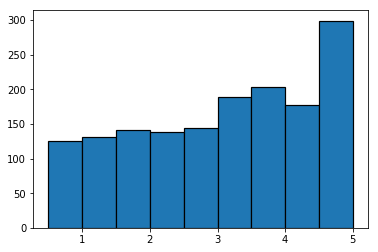

In [13]:
closest_cos_dist = MostSimilarUsers(user_item_mat = ratings_table, coocc_mat = coocc, dist_metric = "cosine", main_user_id = "Chris")
print(closest_cos_dist)

plt.hist(ratings["rating"][ratings["userId"] == closest_cos_dist.index[0]], bins = 9, edgecolor='black', linewidth=1.2)
# Inspect the ratings of the user closest to me to see if his/her taste matches with my own
pd.merge(movieratings[movieratings["userId"] == closest_cos_dist.index[0]].sort_values("rating", ascending = False), chris, on = "movieId")

#### Normalize the user ratings

We center the ratings by subtracting the user's mean rating from every single one of his/her individiual ratings.
This demeaning process takes into account the users that are disproportionally lenient or harsh with their ratings.

In [14]:
ratings_mat = ratings_table.as_matrix()
ratings_mean = np.nanmean(ratings_mat,axis=1)
norm_ratings = ratings_mat - ratings_mean.reshape(-1,1)
scaled_ratings = pd.DataFrame(norm_ratings, index = list(ratings_table.index), columns = list(ratings_table.columns))
print(scaled_ratings.iloc[-1][pd.notnull(scaled_ratings.iloc[-1])])

C:\Users\Chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


6         0.679089
10        0.179089
16        0.679089
32        0.679089
47        1.679089
50        0.179089
70        0.179089
110      -1.320911
111       1.679089
123      -0.820911
215       0.179089
233      -0.320911
260       0.679089
288      -2.320911
293       0.679089
296       1.179089
318       0.679089
347       0.179089
356      -1.320911
364       0.179089
480      -1.320911
501      -0.820911
527       0.679089
541       0.679089
555       1.679089
589       0.179089
592      -1.320911
593       0.679089
608       0.179089
741      -0.320911
778      -0.320911
858       0.679089
866       0.179089
903      -0.320911
904      -0.320911
922      -0.320911
924      -0.820911
1036      0.179089
1076      0.179089
1086      0.179089
1089      1.179089
1092      0.679089
1173     -0.320911
1175     -1.320911
1193      0.179089
1196      0.679089
1198     -1.320911
1200      0.179089
1201     -0.320911
1203      0.679089
1206      0.679089
1208     -1.320911
1209     -0.

(array([  9.,   5.,  30.,  53.,  82., 165., 114.,  19.,   6.]),
 array([-2.32091097, -1.87646653, -1.43202208, -0.98757764, -0.5431332 ,
        -0.09868875,  0.34575569,  0.79020014,  1.23464458,  1.67908903]),
 <a list of 9 Patch objects>)

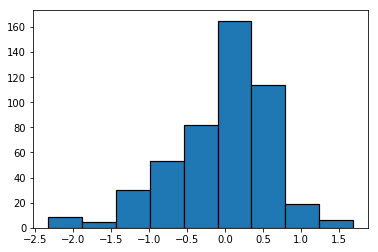

In [15]:
plt.hist(scaled_ratings.iloc[-1][pd.notnull(scaled_ratings.iloc[-1])], bins = 9, edgecolor='black', linewidth=1.2)

#### Compute the distance/similarity between the users [normalized absolute distance]

            dist  cooccurrences
130193  0.494009          192.0
77297   0.530302          177.0
110847  0.533862          182.0
127713  0.535351          111.0
15720   0.548190          232.0
58170   0.548364          208.0
23333   0.553295          211.0
53998   0.555332          267.0
2669    0.555813          217.0
94628   0.556981          147.0


,userId_x,movieId,rating_x,title,genres,userId_y,rating_y
0,130193,1208,4.5,Apocalypse Now (1979),Action|Drama|War,Chris,2.0
1,130193,1221,4.5,"Godfather: Part II, The (1974)",Crime|Drama,Chris,4.0
2,130193,1198,4.5,Raiders of the Lost Ark (Indiana Jones and the...,Action|Adventure,Chris,2.0
3,130193,1196,4.5,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi,Chris,4.0
4,130193,1193,4.5,One Flew Over the Cuckoo's Nest (1975),Drama,Chris,3.5
5,130193,5995,4.5,"Pianist, The (2002)",Drama|War,Chris,3.5
6,130193,111,4.5,Taxi Driver (1976),Crime|Drama|Thriller,Chris,5.0
7,130193,356,4.5,Forrest Gump (1994),Comedy|Drama|Romance|War,Chris,2.0
8,130193,318,4.5,"Shawshank Redemption, The (1994)",Crime|Drama,Chris,4.0
9,130193,296,4.5,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,Chris,4.5


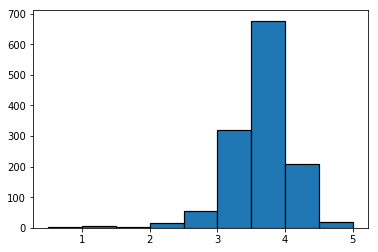

In [16]:
closest_abs_dist = MostSimilarUsers(user_item_mat = scaled_ratings, coocc_mat = coocc, dist_metric = "absolute", main_user_id = "Chris", weighted = True)
print(closest_abs_dist)

plt.hist(ratings["rating"][ratings["userId"] == closest_abs_dist.index[0]], bins = 9, edgecolor='black', linewidth=1.2)
# Inspect the ratings of the user closest to me to see if his/her taste matches with my own
pd.merge(movieratings[movieratings["userId"] == closest_abs_dist.index[0]].sort_values("rating", ascending = False), chris, on = "movieId")

#### Compute the euclidean distance between the users

            dist  cooccurrences
53998   0.044086          267.0
70201   0.044962          282.0
131904  0.045761          341.0
87561   0.045790          341.0
66049   0.047009          269.0
32094   0.047201          353.0
136599  0.047802          266.0
137202  0.047963          283.0
64572   0.048055          278.0
23333   0.048996          211.0


,userId_x,movieId,rating_x,title,genres,userId_y,rating_y
0,53998,32587,5.0,Sin City (2005),Action|Crime|Film-Noir|Mystery|Thriller,Chris,4.0
1,53998,7361,5.0,Eternal Sunshine of the Spotless Mind (2004),Drama|Romance|Sci-Fi,Chris,3.5
2,53998,858,5.0,"Godfather, The (1972)",Crime|Drama,Chris,4.0
3,53998,922,5.0,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),Drama|Film-Noir|Romance,Chris,3.0
4,53998,1617,5.0,L.A. Confidential (1997),Crime|Film-Noir|Mystery|Thriller,Chris,4.0
5,53998,593,5.0,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,Chris,4.0
6,53998,4226,5.0,Memento (2000),Mystery|Thriller,Chris,4.0
7,53998,6874,5.0,Kill Bill: Vol. 1 (2003),Action|Crime|Thriller,Chris,4.5
8,53998,3362,5.0,Dog Day Afternoon (1975),Crime|Drama,Chris,4.0
9,53998,4973,5.0,"Amelie (Fabuleux destin d'Amélie Poulain, Le) ...",Comedy|Romance,Chris,3.5


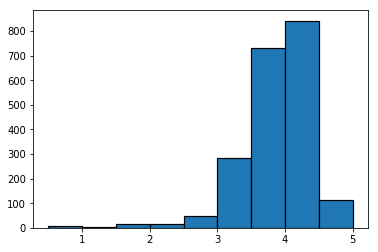

In [17]:
closest_euc_dist = MostSimilarUsers(user_item_mat = scaled_ratings, coocc_mat = coocc, dist_metric = "euclidean", main_user_id = "Chris", weighted = True)
print(closest_euc_dist)

plt.hist(ratings["rating"][ratings["userId"] == closest_euc_dist.index[0]], bins = 9, edgecolor='black', linewidth=1.2)
# Inspect the ratings of the user closest to me to see if his/her taste matches with my own
pd.merge(movieratings[movieratings["userId"] == closest_euc_dist.index[0]].sort_values("rating", ascending = False), chris, on = "movieId")

#### Compute the cosine distance between the users

Now that we have computed and evaluated the absolute distance, let's compute the cosine distance between the pairs of user ratings.

            dist  cooccurrences
64572   0.848226          278.0
67075   0.849642          283.0
71170   0.852638          195.0
118848  0.864708          246.0
34202   0.866650          242.0
132603  0.874729          249.0
122704  0.876368          194.0
41281   0.876456          201.0
105216  0.877260          229.0
137277  0.879572          293.0


,userId_x,movieId,rating_x,title,genres,userId_y,rating_y
0,64572,58559,5.0,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX,Chris,4.5
1,64572,527,5.0,Schindler's List (1993),Drama|War,Chris,4.0
2,64572,4993,5.0,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy,Chris,4.5
3,64572,7153,5.0,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy,Chris,4.5
4,64572,27773,5.0,Old Boy (2003),Mystery|Thriller,Chris,4.5
5,64572,3147,5.0,"Green Mile, The (1999)",Crime|Drama,Chris,4.0
6,64572,79132,5.0,Inception (2010),Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX,Chris,4.0
7,64572,1203,5.0,12 Angry Men (1957),Drama,Chris,4.0
8,64572,2959,5.0,Fight Club (1999),Action|Crime|Drama|Thriller,Chris,4.0
9,64572,48780,5.0,"Prestige, The (2006)",Drama|Mystery|Sci-Fi|Thriller,Chris,3.5


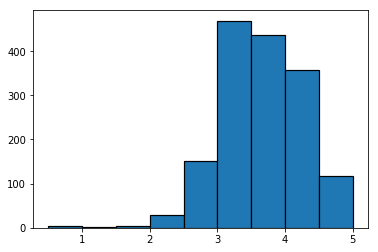

In [18]:
closest_cos_dist = MostSimilarUsers(user_item_mat = scaled_ratings, coocc_mat = coocc, dist_metric = "cosine", main_user_id = "Chris")
print(closest_cos_dist)

plt.hist(ratings["rating"][ratings["userId"] == closest_cos_dist.index[0]], bins = 9, edgecolor='black', linewidth=1.2)
# Inspect the ratings of the user closest to me to see if his/her taste matches with my own
pd.merge(movieratings[movieratings["userId"] == closest_cos_dist.index[0]].sort_values("rating", ascending = False), chris, on = "movieId")

In [19]:
# Save user_item matrix and co-occurrence table as csv for future use
ratings_table.to_csv("ratings_table.csv", sep = "\t")
coocc.to_csv("coocc.csv", sep = "\t")